In [1]:
'''
everything taken from:
https://medium.com/analytics-vidhya/deep-dream-visualizing-the-features-learnt-by-convolutional-networks-in-pytorch-b7296ae3b7f
'''

'\neverything taken from:\nhttps://medium.com/analytics-vidhya/deep-dream-visualizing-the-features-learnt-by-convolutional-networks-in-pytorch-b7296ae3b7f\n'

In [133]:
import torch
from torchvision import models

model = models.googlenet(pretrained=True)

In [134]:
# Freeze all model parameters so they don't change during backpropagation
for param in model.parameters():
    param.requires_grad_(False)

In [135]:
# Show a list of the different layers in the model
list(map(lambda x: x[0], model.named_children()))

['conv1',
 'maxpool1',
 'conv2',
 'conv3',
 'maxpool2',
 'inception3a',
 'inception3b',
 'maxpool3',
 'inception4a',
 'inception4b',
 'inception4c',
 'inception4d',
 'inception4e',
 'maxpool4',
 'inception5a',
 'inception5b',
 'avgpool',
 'dropout',
 'fc']

In [136]:
'''
    https://www.youtube.com/watch?v=1ZbLA7ofasY

A hook is a function that gets called right after you do the forward pass to the next layer

    Parameters
    ----------
    inst: torch.nn.Module
        the layer we want to attach the hook to
    inp: torch.Tensor
        the input to the `forward` method
    out: torch.Tensor
        the output of the `forward` method

It's used to return and be able to save the output of a given layer in the model
'''

activation = {} # dictionary to store the activation of a layer
def create_hook(name):
 def hook(inst, inp, out):
   # copy the output of the given layer
   activation[name] = out
 
 return hook

In [137]:
# register a forward hook for random layer
model.inception4a.register_forward_hook(create_hook('4a'))
# model.features.register_forward_hook(create_hook('feat'))

In [138]:
# normalize the input image to have appropriate mean and standard deviation as specified by pytorch
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
# undo the above normalization if and when the need arises 
denormalize = transforms.Normalize(mean = [-0.485/0.229, -0.456/0.224, -0.406/0.225], std = [1/0.229, 1/0.224, 1/0.225] )

In [139]:
import numpy as np

Height = 28
Width = 28
# generate a numpy array with random values
img = np.single(np.random.uniform(0,1, (3, Height, Width)))
# convert to a torch tensor, normalize, set the requires_grad_ flag
im_tensor = torch.from_numpy(img)
im_tensor.requires_grad_(True)
# im_tensor.to(device)
print(im_tensor.is_leaf)

True


In [140]:
# function to massage img_tensor for using as input to plt.imshow()
def image_converter(im):
    
    # move the image to cpu
    im_copy = im.cpu()
    
    # for plt.imshow() the channel-dimension is the last
    # therefore use transpose to permute axes
    im_copy = denormalize(im_copy.clone().detach()).numpy()
    im_copy = im_copy.transpose(1,2,0)
    
    # clip negative values as plt.imshow() only accepts 
    # floating values in range [0,1] and integers in range [0,255]
    im_copy = im_copy.clip(0, 1) 
    
    return im_copy

In [141]:
import torch.nn as nn
# class to compute image gradients in pytorch
class RGBgradients(nn.Module):
    def __init__(self, weight): # weight is a numpy array
        super().__init__()
        k_height, k_width = weight.shape[1:]
        # assuming that the height and width of the kernel are always odd numbers
        padding_x = int((k_height-1)/2)
        padding_y = int((k_width-1)/2)
        
        # convolutional layer with 3 in_channels and 6 out_channels 
        # the 3 in_channels are the color channels of the image
        # for each in_channel we have 2 out_channels corresponding to the x and the y gradients
        self.conv = nn.Conv2d(3, 6, (k_height, k_width), bias = False, 
                              padding = (padding_x, padding_y) )
        # initialize the weights of the convolutional layer to be the one provided
        # the weights correspond to the x/y filter for the channel in question and zeros for other channels
        weight1x = np.array([weight[0], 
                             np.zeros((k_height, k_width)), 
                             np.zeros((k_height, k_width))]) # x-derivative for 1st in_channel
        
        weight1y = np.array([weight[1], 
                             np.zeros((k_height, k_width)), 
                             np.zeros((k_height, k_width))]) # y-derivative for 1st in_channel
        
        weight2x = np.array([np.zeros((k_height, k_width)),
                             weight[0],
                             np.zeros((k_height, k_width))]) # x-derivative for 2nd in_channel
        
        weight2y = np.array([np.zeros((k_height, k_width)), 
                             weight[1],
                             np.zeros((k_height, k_width))]) # y-derivative for 2nd in_channel
        
        
        weight3x = np.array([np.zeros((k_height, k_width)),
                             np.zeros((k_height, k_width)),
                             weight[0]]) # x-derivative for 3rd in_channel
        
        weight3y = np.array([np.zeros((k_height, k_width)),
                             np.zeros((k_height, k_width)), 
                             weight[1]]) # y-derivative for 3rd in_channel
        
        weight_final = torch.from_numpy(np.array([          weight1x, weight1y, 
weight2x, weight2y,
weight3x, weight3y])).type(torch.FloatTensor)
        
        if self.conv.weight.shape == weight_final.shape:
            self.conv.weight = nn.Parameter(weight_final)
            self.conv.weight.requires_grad_(False)
        else:
            print('Error: The shape of the given weights is not correct')
    
    # Note that a second way to define the conv. layer here would be to pass group = 3 when calling torch.nn.Conv2d
    
    def forward(self, x):
        return self.conv(x)

In [142]:
# Scharr Filters
filter_x = np.array([[-3, 0, 3], 
                     [-10, 0, 10],
                     [-3, 0, 3]])
filter_y = filter_x.T
grad_filters = np.array([filter_x, filter_y])

In [143]:
gradLayer = RGBgradients(grad_filters)

In [144]:
# function to compute gradient loss of an image 
def grad_loss(img, beta = 1, device = 'cpu'):
    
    # move the gradLayer to cuda
    gradLayer.to(device)
    gradSq = gradLayer(img.unsqueeze(0))**2
    
    grad_loss = torch.pow(gradSq.mean(), beta/2)
    
    return grad_loss

In [145]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Calculations being executed on {}'.format(device))
model.to(device)
img_tensor = im_tensor
img_tensor.to(device)
print(img_tensor.is_leaf)

Calculations being executed on cuda
True


In [146]:
import cv2
from torch import optim
import sys
import matplotlib.pyplot as plt

In [147]:
unit_idx = 225 # the neuron to visualize
act_wt = 0.5 # factor by which to weigh the activation relative to the regulizer terms
upscaling_steps = 45 # no. of times to upscale
upscaling_factor = 1.05
optim_steps = 20# no. of times to optimize an input image before upscaling

begin mag_epoch 0, activation: 0.40966323018074036
end mag_epoch: 0, activation: 15.172548294067383


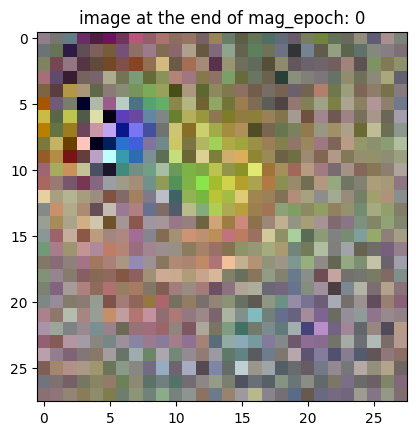

begin mag_epoch 1, activation: 9.550312995910645
end mag_epoch: 1, activation: 15.753620147705078


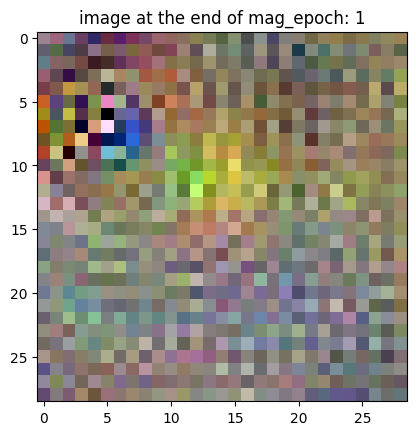

begin mag_epoch 2, activation: 10.462362289428711
end mag_epoch: 2, activation: 16.92506217956543


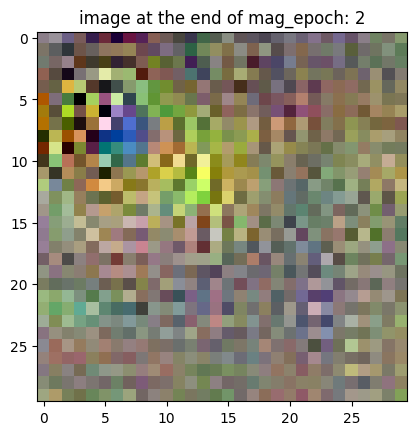

begin mag_epoch 3, activation: 6.722350597381592
end mag_epoch: 3, activation: 9.596331596374512


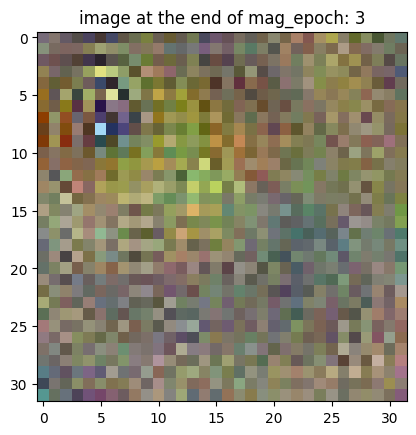

begin mag_epoch 4, activation: 6.813378810882568
end mag_epoch: 4, activation: 9.542243957519531


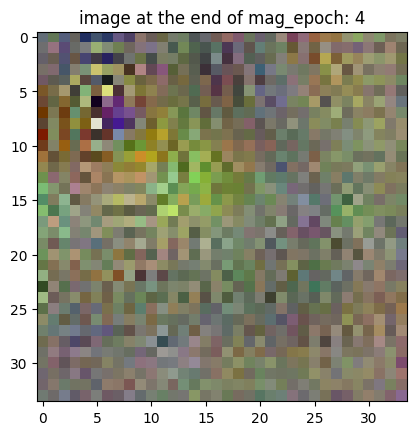

begin mag_epoch 5, activation: 6.8369245529174805
end mag_epoch: 5, activation: 10.35107135772705


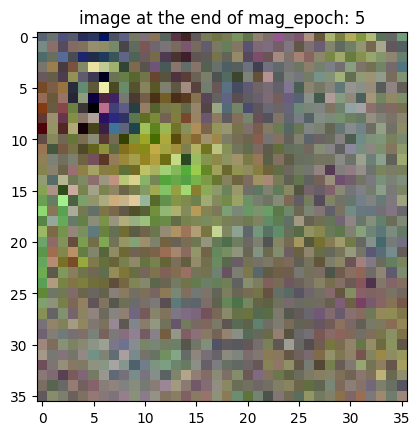

begin mag_epoch 6, activation: 6.633350372314453
end mag_epoch: 6, activation: 10.375008583068848


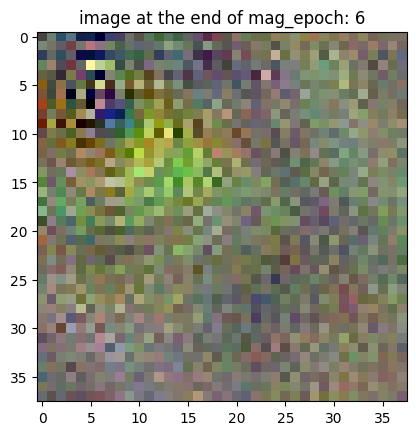

begin mag_epoch 7, activation: 6.839536666870117
end mag_epoch: 7, activation: 10.86594009399414


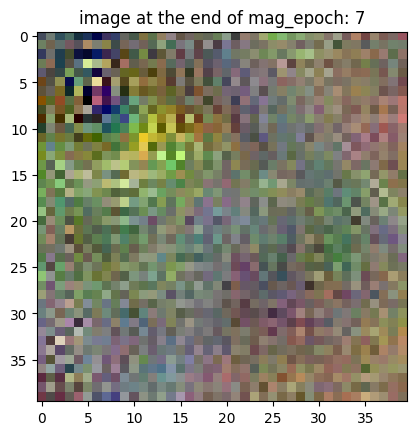

begin mag_epoch 8, activation: 7.523097515106201
end mag_epoch: 8, activation: 10.905647277832031


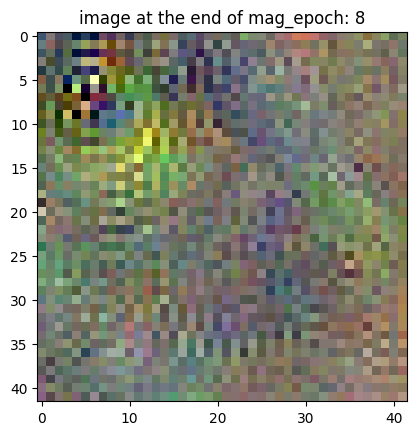

begin mag_epoch 9, activation: 7.248513221740723
end mag_epoch: 9, activation: 11.733412742614746


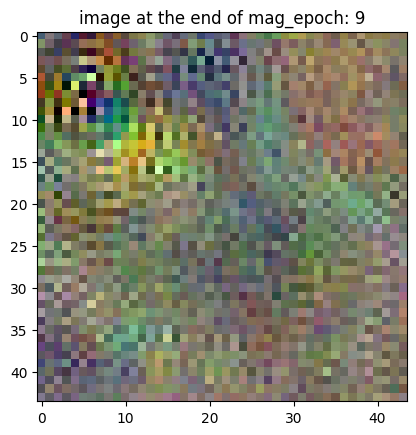

begin mag_epoch 10, activation: 7.875378131866455
end mag_epoch: 10, activation: 11.990428924560547


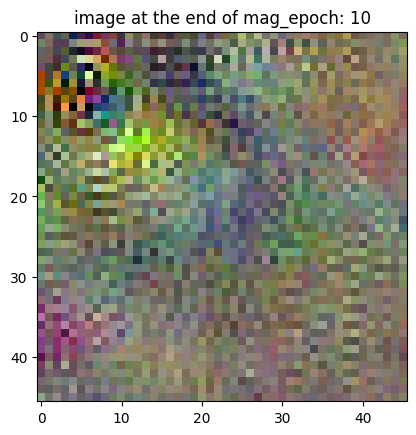

begin mag_epoch 11, activation: 5.436150550842285
end mag_epoch: 11, activation: 7.944680213928223


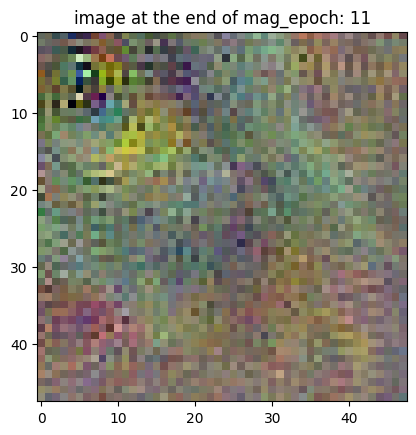

begin mag_epoch 12, activation: 5.408415794372559
end mag_epoch: 12, activation: 8.071876525878906


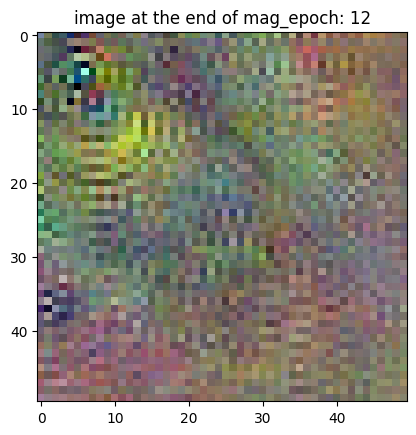

begin mag_epoch 13, activation: 5.175121784210205
end mag_epoch: 13, activation: 8.127854347229004


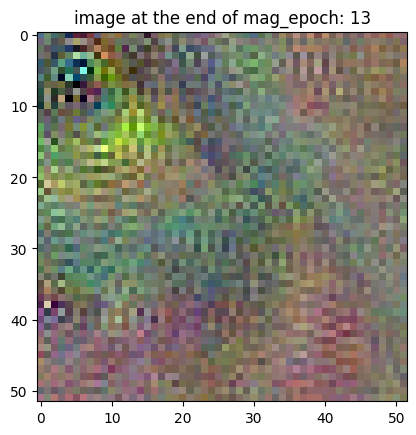

begin mag_epoch 14, activation: 5.6649489402771
end mag_epoch: 14, activation: 9.156269073486328


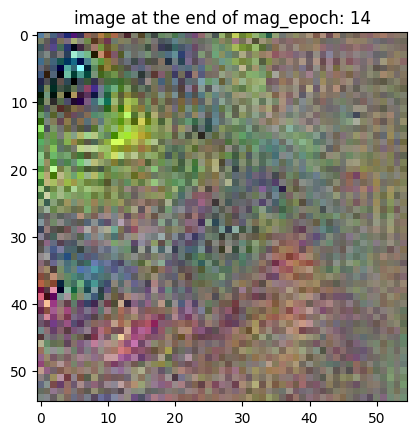

begin mag_epoch 15, activation: 5.463118076324463
end mag_epoch: 15, activation: 10.60031795501709


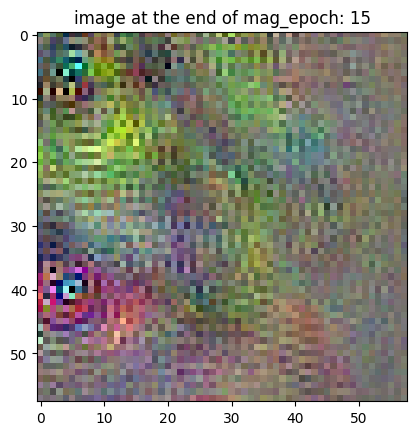

begin mag_epoch 16, activation: 6.417418479919434
end mag_epoch: 16, activation: 11.52765941619873


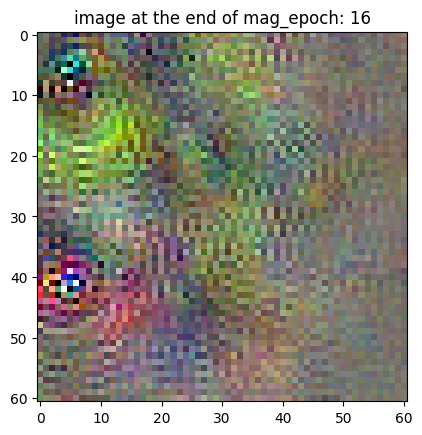

begin mag_epoch 17, activation: 4.898805618286133
end mag_epoch: 17, activation: 8.494574546813965


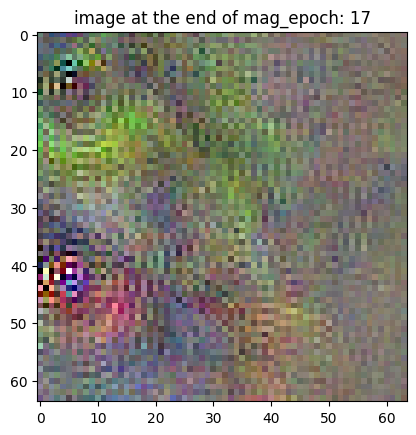

begin mag_epoch 18, activation: 4.607702732086182
end mag_epoch: 18, activation: 10.941205024719238


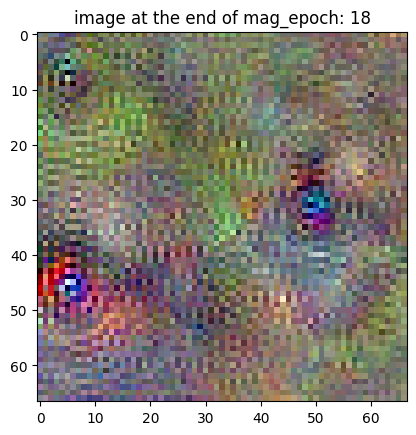

begin mag_epoch 19, activation: 5.718395233154297
end mag_epoch: 19, activation: 11.626978874206543


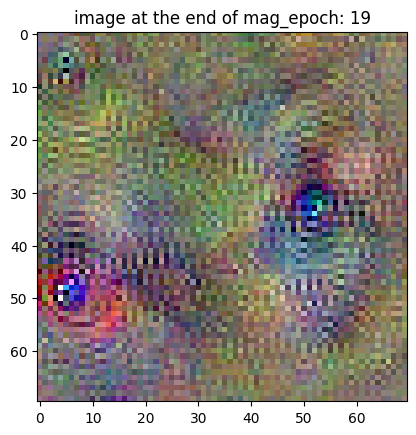

begin mag_epoch 20, activation: 6.2103190422058105
end mag_epoch: 20, activation: 13.400629997253418


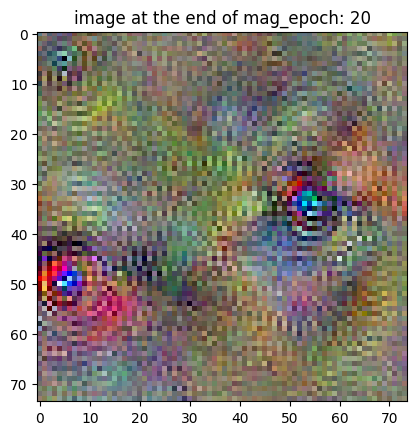

begin mag_epoch 21, activation: 6.4327826499938965
end mag_epoch: 21, activation: 13.265240669250488


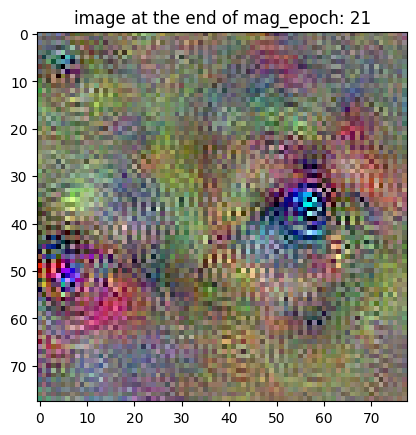

begin mag_epoch 22, activation: 5.553744792938232
end mag_epoch: 22, activation: 11.254667282104492


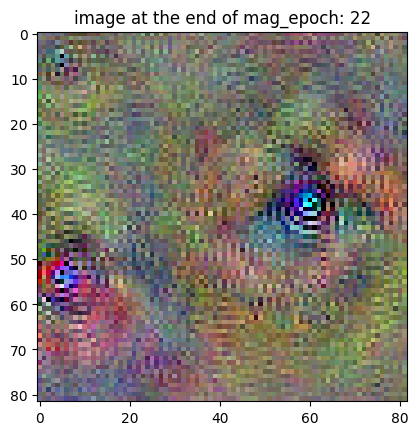

begin mag_epoch 23, activation: 5.752455234527588
end mag_epoch: 23, activation: 11.66235065460205


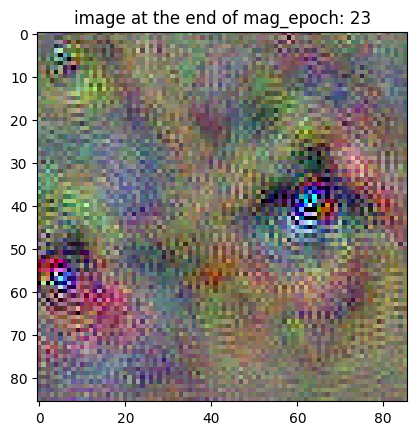

begin mag_epoch 24, activation: 6.0662007331848145
end mag_epoch: 24, activation: 12.143444061279297


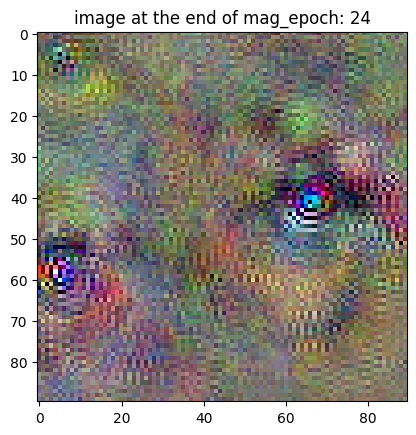

begin mag_epoch 25, activation: 6.406984806060791
end mag_epoch: 25, activation: 13.768072128295898


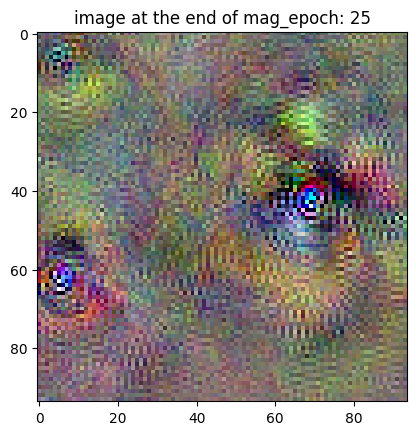

begin mag_epoch 26, activation: 5.42847204208374
end mag_epoch: 26, activation: 10.328533172607422


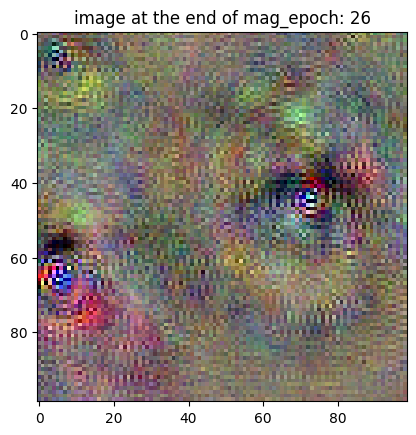

begin mag_epoch 27, activation: 5.485491752624512
end mag_epoch: 27, activation: 10.8523588180542


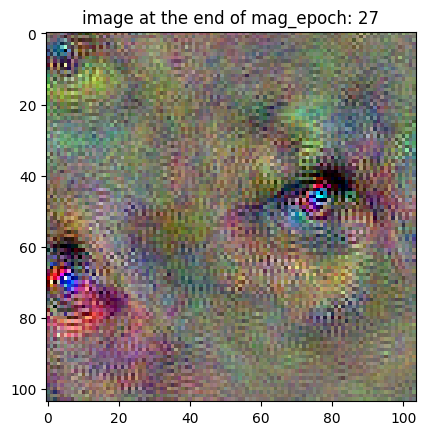

begin mag_epoch 28, activation: 6.02148962020874
end mag_epoch: 28, activation: 11.550786972045898


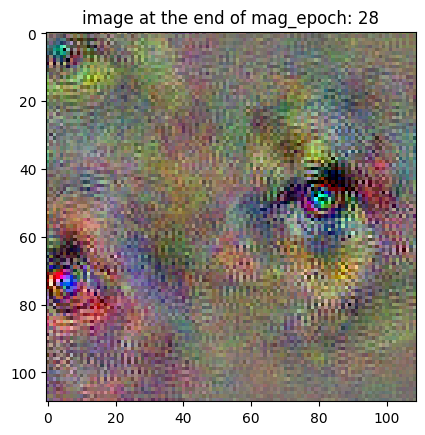

begin mag_epoch 29, activation: 5.49028205871582
end mag_epoch: 29, activation: 10.217421531677246


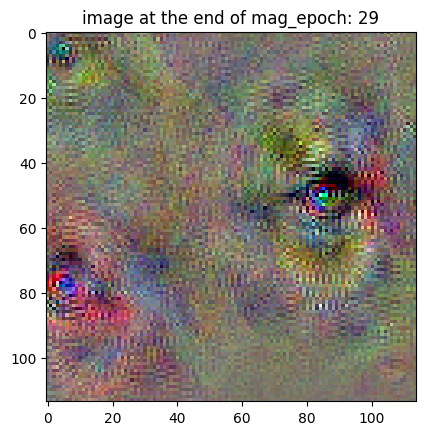

begin mag_epoch 30, activation: 5.215610027313232
end mag_epoch: 30, activation: 11.269243240356445


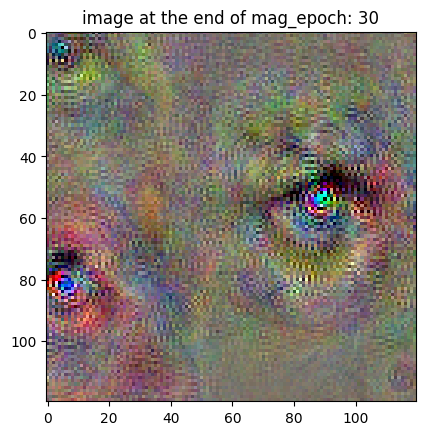

begin mag_epoch 31, activation: 5.388534069061279
end mag_epoch: 31, activation: 10.0554838180542


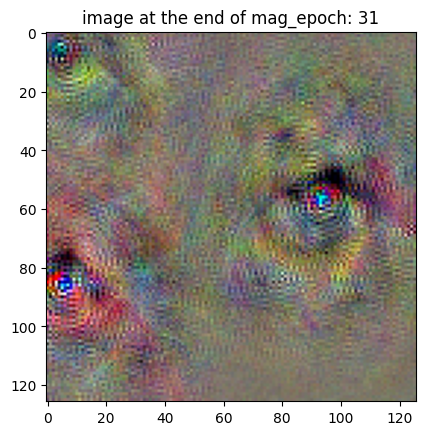

begin mag_epoch 32, activation: 4.787437915802002
end mag_epoch: 32, activation: 9.317214965820312


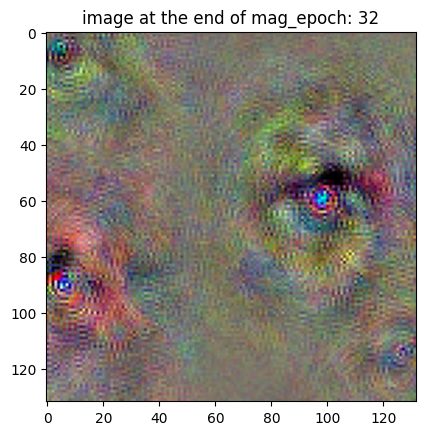

begin mag_epoch 33, activation: 4.995915412902832
end mag_epoch: 33, activation: 9.727660179138184


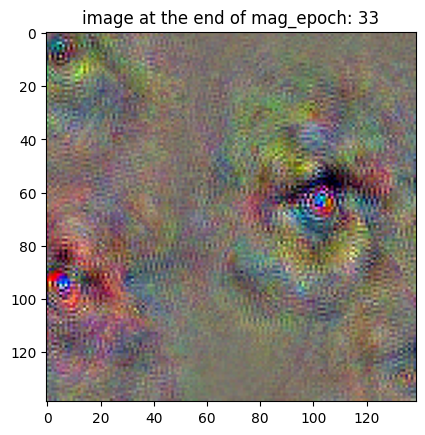

begin mag_epoch 34, activation: 4.208867073059082
end mag_epoch: 34, activation: 8.362959861755371


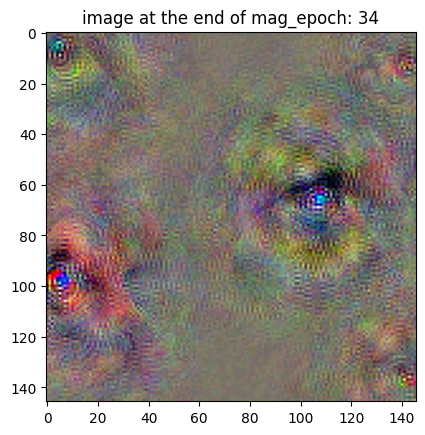

begin mag_epoch 35, activation: 4.227264404296875
end mag_epoch: 35, activation: 9.149888038635254


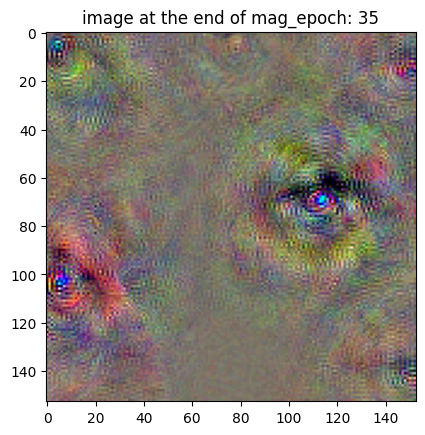

begin mag_epoch 36, activation: 4.241422176361084
end mag_epoch: 36, activation: 8.26343059539795


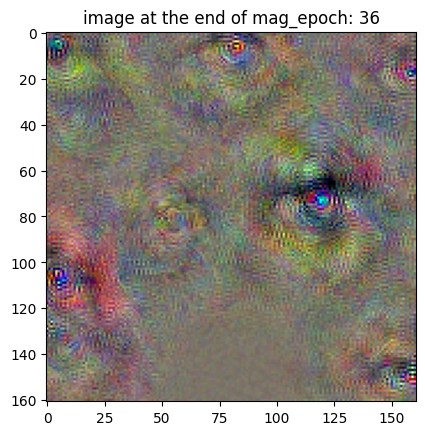

begin mag_epoch 37, activation: 4.526214122772217
end mag_epoch: 37, activation: 9.63873291015625


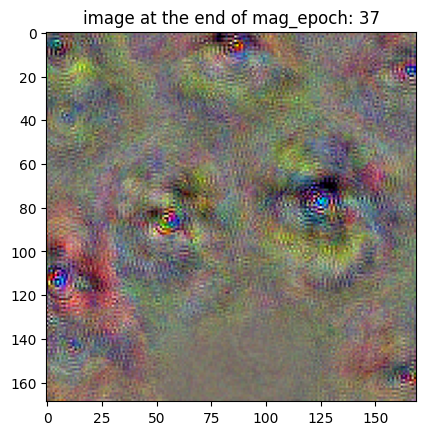

begin mag_epoch 38, activation: 4.609567642211914
end mag_epoch: 38, activation: 9.316362380981445


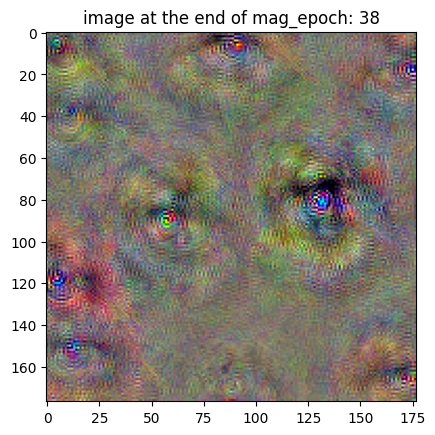

begin mag_epoch 39, activation: 4.740192890167236
end mag_epoch: 39, activation: 9.76833724975586


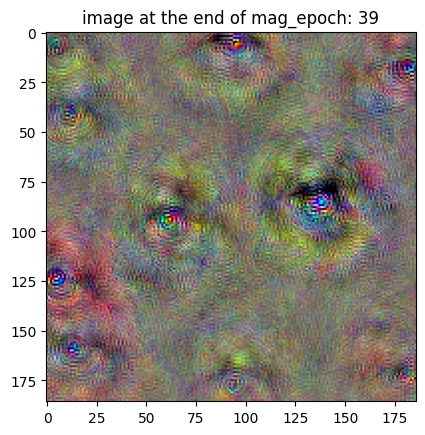

begin mag_epoch 40, activation: 4.630825519561768
end mag_epoch: 40, activation: 9.554945945739746


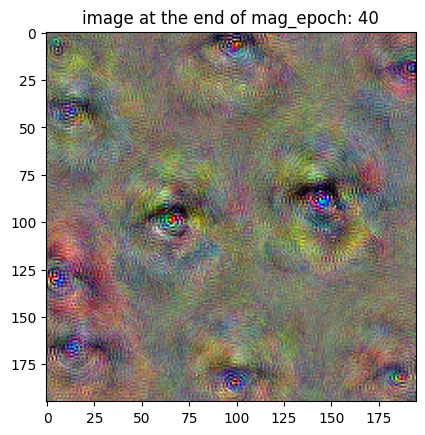

begin mag_epoch 41, activation: 5.019109725952148
end mag_epoch: 41, activation: 9.899595260620117


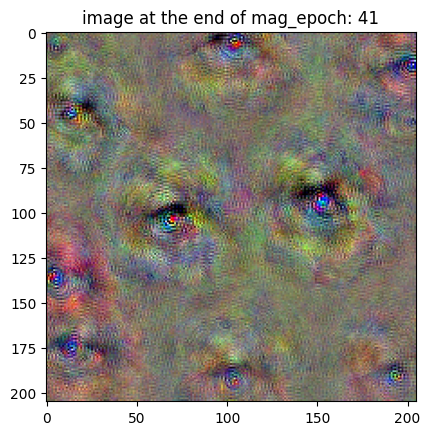

begin mag_epoch 42, activation: 4.64517068862915
end mag_epoch: 42, activation: 9.703178405761719


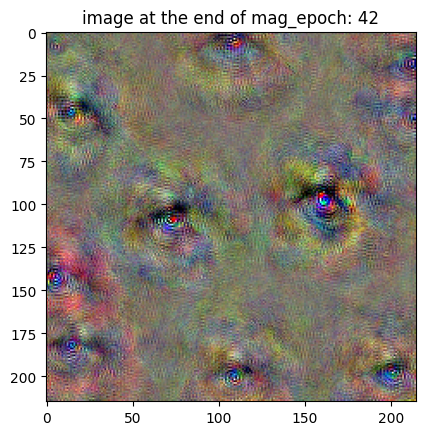

begin mag_epoch 43, activation: 4.524255275726318
end mag_epoch: 43, activation: 9.099865913391113


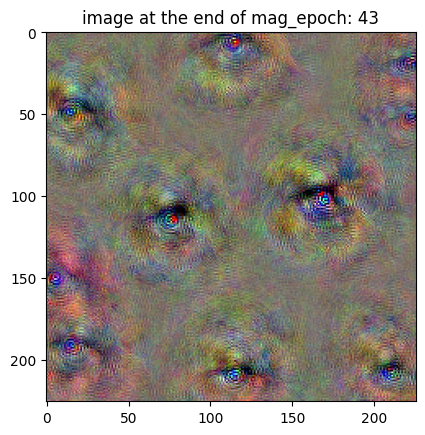

begin mag_epoch 44, activation: 4.439680576324463
end mag_epoch: 44, activation: 9.25101375579834


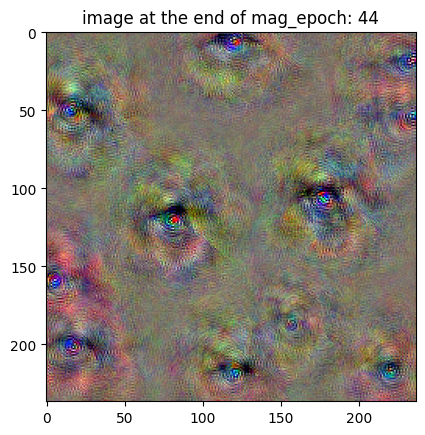

begin mag_epoch 45, activation: 4.575789928436279
end mag_epoch: 45, activation: 9.321629524230957


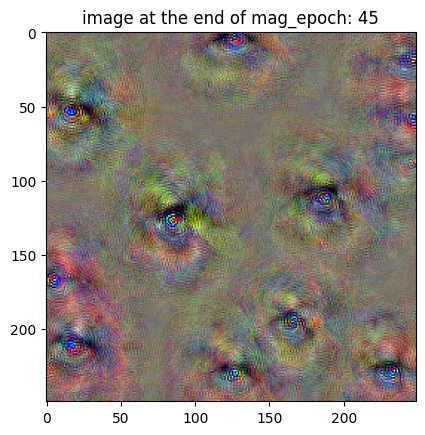

In [149]:
model.eval()

for mag_epoch in range(upscaling_steps+1):
    optimizer = optim.Adam([img_tensor], lr = 0.4)
    
    for opt_epoch in range(optim_steps):
        optimizer.zero_grad()
        # model(img_tensor.unsqueeze(0).to(device))
        model(img_tensor.unsqueeze(0).to(device))
        layer_out = activation['4a']
        rms = torch.pow((layer_out[0, unit_idx]**2).mean(), 0.5)
        # terminate if rms is nan
        if torch.isnan(rms):
            print('Error: rms was Nan; Terminating ...')
            sys.exit()
        
        # pixel intensity
        pxl_inty = torch.pow((img_tensor**2).mean(), 0.5)
        # terminate if pxl_inty is nan
        if torch.isnan(pxl_inty):
            print('Error: Pixel Intensity was Nan; Terminating ...')
            sys.exit()
            
        # image gradients
        im_grd = grad_loss(img_tensor.to(device), beta = 1, device = device)
        # terminate is im_grd is nan
        if torch.isnan(im_grd):
            print('Error: image gradients were Nan; Terminating ...')
            sys.exit()
        
        loss = -act_wt*rms + pxl_inty + im_grd        
        # print activation at the beginning of each mag_epoch
        if opt_epoch == 0:
            print('begin mag_epoch {}, activation: {}'.format(mag_epoch, rms))
        loss.backward()
        optimizer.step()
        
    # view the result of optimising the image
    print('end mag_epoch: {}, activation: {}'.format(mag_epoch, rms))
    img = image_converter(img_tensor)    
    plt.imshow(img)
    plt.title('image at the end of mag_epoch: {}'.format(mag_epoch))
    plt.show()
    
    img = cv2.resize(img, dsize = (0,0), 
                     fx = upscaling_factor, fy = upscaling_factor).transpose(2,0,1) # scale up and move the batch axis to be the first
    img_tensor = normalize(torch.from_numpy(img)).to(device).requires_grad_(True)